In [14]:
# Decide how much augmentation is needed by adding the fraction
augment = 0.4

In [1]:
import librosa
import pandas as pd
import soundfile as sf
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import librosa
import numpy as np
from scipy.io import wavfile
from IPython.display import Audio
from utils import (
    train_test_split_util,
    meta,
    get_waves,
    extract_features,
    split_audio,
    bell,
    split_audio2,
    get_waves_5_sec,
)
from audiomentations import (
    Compose,
    AddGaussianNoise,
    TimeStretch,
    Gain,
    PitchShift,
    RoomSimulator,
)
from tensorflow.keras.callbacks import ModelCheckpoint


/var/folders/49/ptrwr_w135x7rbt0__3kv5080000gp/T/ipykernel_4479/3647293026.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Data Preprocessing

## Train Test Split using utils(Run if only needed unsplitted_data)

In [9]:
train_x, test_x, train_y, test_y = train_test_split_util()

Function Name: train_test_split_util
Time Taken: 0.2574 seconds


In [10]:
train_x_wave, train_x_sr = get_waves(train_x, base_path = "/Users/Licious/project/unipd/hda_dataset/audio/")

Function Name: get_waves
Time Taken: 9.0946 seconds


In [11]:
test_x_wave, test_x_sr = get_waves(test_x, base_path = "/Users/Licious/project/unipd/hda_dataset/audio/")

Function Name: get_waves
Time Taken: 0.9866 seconds


## Augmentation 

In [12]:
#erann

audio_augment = Compose([
        AddGaussianNoise(min_amplitude=0.01, max_amplitude=0.15, p=1),
        PitchShift(min_semitones=-6, max_semitones=6, p=1),
        TimeStretch(min_rate=.75, max_rate=1.25,p=1),
        # Gain(min_gain_in_db=-12, max_gain_in_db=-12, p=1),
        # RoomSimulator(p=1, leave_length_unchanged=True)
])

In [28]:
num_augmented = int(len(train_x_sr)*augment)
augmented_img, aug_train_y = None, None
if augment:
    #genreate augmented images from the first num_augmented clips and concatenate them to the train images
    augmented_img = np.array([audio_augment(samples=clip, sample_rate=train_x_sr[0]) for clip in train_x_wave[:num_augmented]])
    aug_train_y =  train_y[:num_augmented]

## Feature Extraction

In [16]:

train = extract_features(train_x_wave, ft="mel", n_mfcc=128, sr=44100)
test = extract_features(test_x_wave, ft="mel", n_mfcc=128, sr=44100)
aug_train = extract_features(test_x_wave, ft="mel", n_mfcc=128, sr=44100)


Function Name: extract_features
Time Taken: 32.0127 seconds
Function Name: extract_features
Time Taken: 7.8404 seconds
Function Name: extract_features
Time Taken: 7.1506 seconds


# Model creation and fiting

In [7]:
tf.compat.v1.set_random_seed(
    42
)

### Model Create Erann

In [2]:
# erann

import tensorflow as tf
from tensorflow.keras import layers, models


def CC1(i):
    if i==1 or i==2:
      return 3
    elif i==4:
      return 6


def CC2(j):
    if j==1 or j==2:
      return 3
    elif j==4:
      return 5

def P(x):
    if x==1 or x==2:
        return 1
    elif x==4:
        return 2


def create_arb_block(input_tensor, x, y, c, layer=2):
    conv = None
    if layer != 1:
        conv = layers.BatchNormalization()(input_tensor)
        conv = layers.LeakyReLU(0.01)(conv)
        conv = layers.Conv2D(
            c, kernel_size=(CC1(x), CC1(y)), strides=(x, y), padding="same"
        )(conv)
    else:
        conv = layers.Conv2D(
            c, kernel_size=(CC1(x), CC1(y)), strides=(x, y), padding="same"
        )(input_tensor)

    conv = layers.BatchNormalization()(conv)
    conv = layers.LeakyReLU(0.01)(conv)
    conv = layers.Conv2D(c, (CC2(x), CC2(y)), strides=(1, 1), padding="same")(conv)

    if x != 1 or y != 1:
        combined_tensors = [conv]
        residual = layers.Conv2D(c, (1, 1), (x, y), padding="valid")(input_tensor)
        combined_tensors.append(residual)
        output_tensor = layers.Add()(combined_tensors)
        output_tensor = layers.Dropout(0.2)(output_tensor)
        return output_tensor
    return conv


def s(i):
    sm = 1
    return 2 if i > sm else 4



def create_eranns_architecture(input_shape, decreasing_temporal_size_parameter, num_classes):
    F0, T0, C0 = 128, 320, 1
    sm = decreasing_temporal_size_parameter
    W = 1

    model = models.Sequential()
    # Feature extractor
    erann_input = layers.Input(shape=input_shape)
    erann = layers.BatchNormalization()(erann_input)
    #Stage 0
    erann = create_arb_block(erann, 1, 1 , 8, layer = 1)
    erann = create_arb_block(erann, 1, 1 , 8,)
    erann = create_arb_block(erann, 1, 1 , 8)
    erann = create_arb_block(erann, 1, 1 , 8)

    #Stage 1
    erann = create_arb_block(erann, 2, s(1), 16)
    erann = create_arb_block(erann, 1, 1, 16)
    erann = create_arb_block(erann, 1, 1, 16)
    erann = create_arb_block(erann, 1, 1, 16)


    #Stage 2
    erann = create_arb_block(erann, 2, s(2), 32)
    erann = create_arb_block(erann, 1, 1, 32)
    erann = create_arb_block(erann, 1, 1, 32)
    erann = create_arb_block(erann, 1, 1, 32)


    #Stage 3
    erann = create_arb_block(erann, 2, s(3), 64)
    erann = create_arb_block(erann, 1, 1, 64)
    erann = create_arb_block(erann, 1, 1, 64)
    erann = create_arb_block(erann, 1, 1, 64)


    #Stage 4
    erann = create_arb_block(erann, 2, 2, 128)
    erann = create_arb_block(erann, 1, 1, 128)
    erann = create_arb_block(erann, 1, 1, 128)
    erann = create_arb_block(erann, 1, 1, 128)


    average_pool = layers.GlobalAveragePooling2D()(erann)
    erann = layers.Dense(128 * W)(average_pool)
    print(erann.shape)
    erann = layers.LeakyReLU(0.01)(erann)

    erann = layers.Dense(num_classes, activation='softmax')(erann)
    print(erann.shape)
    erann_model = models.Model(inputs=erann_input, outputs=erann)
    return erann_model

audio_input_shape = (128, 640, 1)
num_classes = 50 

sm_value = 1

eranns_model = create_eranns_architecture(audio_input_shape, sm_value, num_classes)

eranns_model.summary()

2024-02-17 01:44:30.902369: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-02-17 01:44:30.902438: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-02-17 01:44:30.902449: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-02-17 01:44:30.902838: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-17 01:44:30.903137: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


(None, 128)
(None, 50)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 640, 1)]        0         []                            
                                                                                                  
 batch_normalization (Batch  (None, 128, 640, 1)          4         ['input_1[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 conv2d (Conv2D)             (None, 128, 640, 8)          80        ['batch_normalization[0][0]'] 
                                                                                                  
 batch_normalization_1 (Bat  (None, 128, 640, 8)          32        ['c

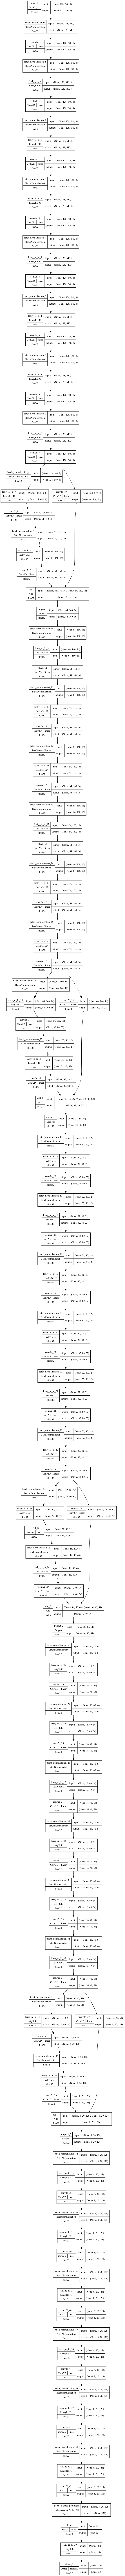

In [4]:
# plot model
tf.keras.utils.plot_model(
    eranns_model,
    to_file='model2.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
    show_trainable=False
)


### Function train_model

In [6]:
def train_model(model, train, label, model_file):

    checkpoint_filepath = f"model-erann/{model_file}.h5"
    checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_best_only=True,
        monitor="val_accuracy",
        mode="max",
        restore_best_weights=True,
        verbose=0,
    )

    model.compile(
        optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )

    model.fit(
        train,
        np.array(label),
        epochs=600,
        batch_size=50,
        validation_split=0.1,  # 1% of data for validation
        shuffle=True,
        use_multiprocessing=True,
        callbacks=[checkpoint_callback],
    )
    return model

### Function test_model

In [5]:
## Test model
def test_model(model, test, label):
    test_loss, test_acc = model.evaluate(test,
        np.array(label),
    )
    return test_acc

#### Step 1 train model on pure data without augmentation

In [ ]:
eranns_model = train_model(eranns_model, train, train_y,"intermdiate_model")
test_model(eranns_model, test, test_y)

<bold>If training accuracy is low, we can run with more epochs</bold>

#### Step 2 adding augmentation to retrain to fine tune the model

In [34]:
train_aug2 = np.concatenate((train, aug_train))
train_y_aug2 = np.concatenate((train_y, aug_train_y))

#### Step 3 Retrain on new augmented

In [ ]:
eranns_model = train_model(eranns_model, train_aug2, train_y_aug2, "aug_model")
test_model(eranns_model, test, test_y)

# Test the model on previous run

In [ ]:
from tensorflow.keras.models import load_model
model = load_model(f"model-erann/final_69_5.h5")
test_model(eranns_model, test, test_y)